# Experiment 11 - VGG16 trainable

## Model creation

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini/'

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [7]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malign
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]

In [8]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
from skimage.color import gray2rgb

import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [9]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image.reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    tmp_images.append(rgb_image)
  tmp_images = np.array(tmp_images)
  return tmp_images
images = toRGB(images)

In [ ]:
from keras.layers import Input
from keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input

pretrained_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
pretrained_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
from keras.layers import Input
from keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input

pretrained_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
pretrained_model.trainable = False

model = models.Sequential()
model.add(pretrained_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid',name='classifier_hidden'))
model.summary()

# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]

datagen = ImageDataGenerator(
    validation_split=0.2 ,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range = 10,
    zoom_range=0.3,
    preprocessing_function=preprocess
)

valid_datagen = ImageDataGenerator(validation_split=0.2)


train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED,
                               subset="training")

valid_generator = valid_datagen.flow(images,
                               labels,
                               batch_size=32,
                               subset="validation",
                               seed=SEED)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))

#FIRST STEP: TRAIN LAST LAYER

optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=False, mode='min',save_weights_only=True)
history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=3)

#SECOND STEP: TRAIN TOP 11 LAYERS

model.load_weights(checkpoint_filepath)

optimizer = tf.keras.optimizers.Adam(1e-4)

bottom_layers_number = len(pretrained_model.layers)-11
count = 0
for layer in pretrained_model.layers:
  if count > bottom_layers_number:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=False, mode='min',save_weights_only=True)
history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=10)

#THIRD STEP: TRAIN ALL LAYERS

model.load_weights(checkpoint_filepath)

optimizer = tf.keras.optimizers.Adam(1e-5)

pretrained_model.trainable = True

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=187)

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
classifier_hidden (Dense)    (None, 1)                 257       
Total params: 19,041,089
Trainable params: 4,326,401
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/3
66/66 [==============================] - 22s 282ms/step - loss: 0.7771 - accuracy: 0.5507 - 

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/pretrained_vgg16_trainable_bm"))
with open(out_path+'/histories/pretrained_vgg16_trainable_bm_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/Pretrained/vgg16_learning_bm/assets


## Model evaluation

In [10]:
# load model and model's history
with open(out_path + '/histories/pretrained_vgg16_trainable_bm_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable_bm"))

In [11]:
index = history['val_loss'].index(min(history['val_loss']))
print("Epochs: ", index)
print("Accuracy: ", history['accuracy'][index])
print("Loss: ", history['loss'][index])
print("Val accuracy: ", history['val_accuracy'][index])
print("Val loss: ", history['val_loss'][index])

Epochs:  25
Accuracy:  0.7524893283843994
Loss:  0.4792492389678955
Val accuracy:  0.76171875
Val loss:  0.4879274070262909


In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
#test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))

test_images_tensor = toRGB(test_images_tensor)
#test_images_tensor = test_images_tensor.astype('float32') / 65535


test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)

11/11 [==============================] - 9s 115ms/step - loss: 0.5677 - accuracy: 0.7232


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


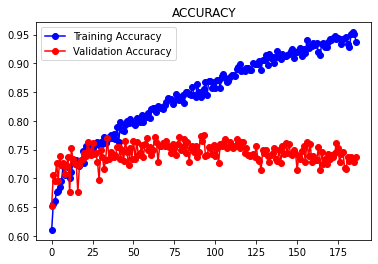

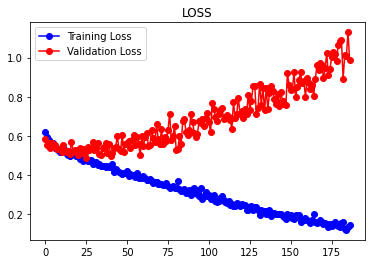

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

[[163  56]
 [ 37  80]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78       219
           1       0.59      0.68      0.63       117

    accuracy                           0.72       336
   macro avg       0.70      0.71      0.71       336
weighted avg       0.74      0.72      0.73       336



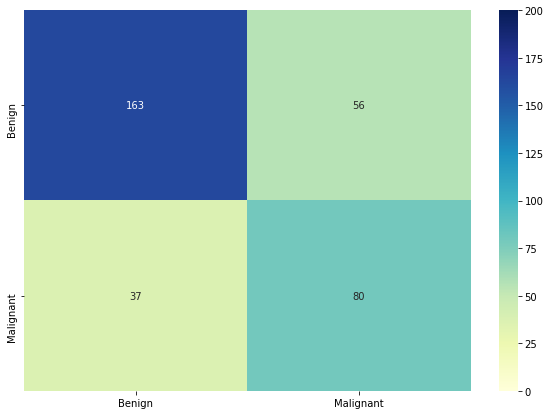

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

# Experiment 12 - Inception V3 trainable

## Model creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini/'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image.reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    tmp_images.append(rgb_image)
  tmp_images = np.array(tmp_images)
  return tmp_images

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]
images = toRGB(images)

In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
from skimage.color import gray2rgb

import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
from keras.layers import Input
from keras import applications


pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(150,150,3))
pretrained_model.trainable=True

model = tf.keras.models.Sequential()
model.add(pretrained_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid',name='classifier_hidden'))
model.summary()

# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]


datagen = ImageDataGenerator(
    validation_split=0.2 ,
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range=[0.7,1.3],
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator(#rescale=1./65535.,
                                   validation_split=0.2)


train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED,
                               subset="training")

valid_generator = valid_datagen.flow(images,
                               labels,
                               batch_size=32,
                               subset="validation",
                               seed=SEED)



STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))


optimizer = tf.keras.optimizers.Adam(1e-5)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=250)

model.load_weights(checkpoint_filepath)

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/pretrained_inception_trainable_bm"))
with open(out_path+'/histories/pretrained_inception_trainable_bm_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/Pretrained/inception_all_layers_fine_tuned_bm/assets


## Model evaluation

In [12]:
# load model and model's history
with open(out_path + '/histories/pretrained_inception_trainable_bm_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_trainable_bm"))

In [13]:
index = history['val_loss'].index(min(history['val_loss']))
print("Epochs: ", index)
print("Accuracy: ", history['accuracy'][index])
print("Loss: ", history['loss'][index])
print("Val accuracy: ", history['val_accuracy'][index])
print("Val loss: ", history['val_loss'][index])

Epochs:  13
Accuracy:  0.7136083245277405
Loss:  0.5333201885223389
Val accuracy:  0.708984375
Val loss:  0.575926661491394


In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
#test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))

test_images_tensor = toRGB(test_images_tensor)
#test_images_tensor = test_images_tensor.astype('float32') / 65535


test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)

11/11 [==============================] - 10s 150ms/step - loss: 0.5984 - accuracy: 0.6607


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


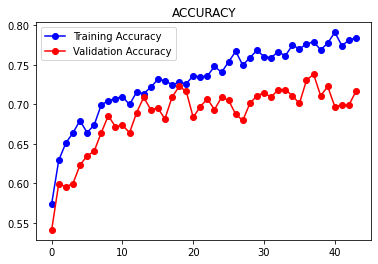

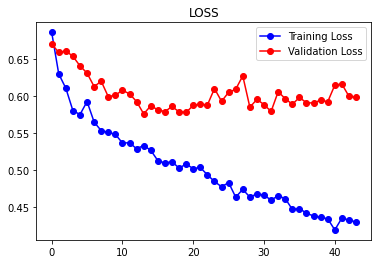

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

[[140  79]
 [ 35  82]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       219
           1       0.51      0.70      0.59       117

    accuracy                           0.66       336
   macro avg       0.65      0.67      0.65       336
weighted avg       0.70      0.66      0.67       336



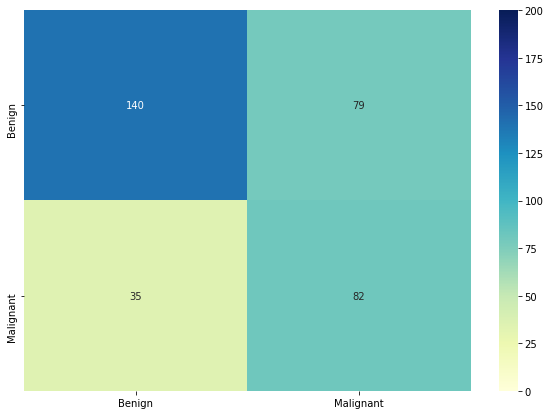

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))